In [1]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

import warnings
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# 設定 data_path
data_path = 'D:/Coding Project/GitHub/ML100-Days/data/Kaggle/Midterm exam for ML 100 marathon by Cupoy/'
df_submission = pd.read_csv(data_path + 'sample_submission.csv', header = 'infer')
df_train = pd.read_csv(data_path + 'train_data.csv', header = 'infer')
df_test = pd.read_csv(data_path + 'test_features.csv', header = 'infer')
print('Train shape:', df_train.shape)
print('Test shape:', df_test.shape)
print('Sample_submission shape:', df_submission.shape)
df_train['poi_code'] = df_train['poi'].map({True:1, False:0}).astype('int') # (Person-of-Interest, poi)
df_train = df_train.drop(['poi'] , axis = 1)
train_X =  df_train.drop(['poi_code'] , axis = 1)
df_train.head()

Train shape: (113, 22)
Test shape: (33, 21)
Sample_submission shape: (33, 2)


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,poi_code
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0,1
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0,1
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0,1
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0,1
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0,1


In [3]:
df = pd.concat([train_X, df_test])
df.reset_index(inplace = True, drop = True)
print('df shape:', df.shape)
print(df.info())
df.head()

df shape: (146, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 21 columns):
name                         146 non-null object
bonus                        82 non-null float64
deferral_payments            39 non-null float64
deferred_income              49 non-null float64
director_fees                17 non-null float64
email_address                111 non-null object
exercised_stock_options      102 non-null float64
expenses                     95 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
loan_advances                4 non-null float64
long_term_incentive          66 non-null float64
other                        93 non-null float64
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
salary                       95 non-null float64
shared_receipt_with_poi      86 non-null 

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


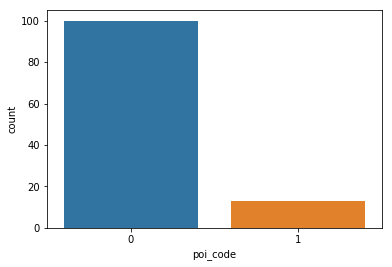

In [4]:
sns.countplot(df_train['poi_code'])

In [5]:
df['email'] = df['email_address'].apply(lambda x : str(x).replace("@enron.com","").strip().split(' '))
df = df.drop(['email_address'] , axis = 1)

### Missing Values Processing

In [6]:
# 秀出資料欄位的類型與數量
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "ColumnType"]
dtype_df = dtype_df.groupby("ColumnType").aggregate('count').reset_index()
print(dtype_df.head())

# Select Numerical columns
numeric_columns = []
for col, dtype in zip(df.columns, df.dtypes):
    if dtype == 'int64' or dtype == 'float64':
        numeric_columns.append(col)
        
# Remove dtype = 'bool', usually is (0, 1)
numeric_columns = list(df[numeric_columns].columns[list(df[numeric_columns].apply(lambda x:len(x.unique())!=2 ))])

# Replacing missing Values with mean
for dtype, col in zip(df.dtypes, df.columns):
    if dtype == 'float64':
        mean = df[col].mean()
        df[col] = np.where(df[col].isnull(), mean, df[col])
    else:
    df_temp[col] = LabelEncoder().fit_transform(df[col])

  ColumnType  Count
0    float64     19
1     object      2


### Outlier Processing

In [7]:
df[numeric_columns].describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,146.000000,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,146.000000,1.460000e+02,1.460000e+02
mean,2.374235e+06,1.642674e+06,-1.140475e+06,1.668049e+05,5.987054e+06,1.087289e+05,608.790698,64.895349,41.232558,4.196250e+07,1.470361e+06,9.190650e+05,2.321741e+06,1.664106e+05,5.621943e+05,1176.465116,2073.860465,5.081526e+06,6.773957e+06
std,8.007241e+06,2.642530e+06,2.316042e+06,1.062621e+05,2.592425e+07,4.295787e+05,1409.571983,66.594918,76.620127,6.772401e+06,3.978880e+06,3.655543e+06,1.085360e+07,1.438614e+06,2.187100e+06,902.168879,1977.423036,2.687498e+07,3.617138e+07
min,7.000000e+04,-1.025000e+05,-2.799289e+07,3.285000e+03,3.285000e+03,1.480000e+02,12.000000,0.000000,0.000000,4.000000e+05,6.922300e+04,2.000000e+00,-2.604490e+06,-7.576788e+06,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,7.125000e+05,1.642674e+06,-1.140475e+06,1.668049e+05,7.578650e+05,3.384850e+04,36.000000,25.750000,6.000000,4.196250e+07,5.441688e+05,2.686500e+03,3.605280e+05,1.664106e+05,2.398005e+05,591.500000,904.250000,5.544675e+05,6.129080e+05
50%,2.374235e+06,1.642674e+06,-1.140475e+06,1.668049e+05,2.250522e+06,8.247450e+04,608.790698,64.895349,41.232558,4.196250e+07,1.470361e+06,4.013055e+05,7.759920e+05,1.664106e+05,3.233105e+05,1176.465116,2073.860465,1.354124e+06,1.710454e+06
75%,2.374235e+06,1.642674e+06,-7.008965e+05,1.668049e+05,5.987054e+06,1.087289e+05,608.790698,64.895349,41.232558,4.196250e+07,1.470361e+06,9.190650e+05,2.321741e+06,1.664106e+05,5.621943e+05,1176.465116,2073.860465,3.625040e+06,6.331709e+06
max,9.734362e+07,3.208340e+07,-8.330000e+02,1.398517e+06,3.117640e+08,5.235198e+06,14368.000000,528.000000,609.000000,8.392500e+07,4.852193e+07,4.266759e+07,1.303223e+08,1.545629e+07,2.670423e+07,5521.000000,15149.000000,3.098866e+08,4.345095e+08


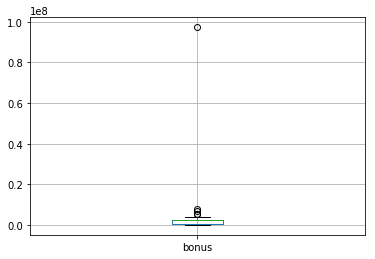

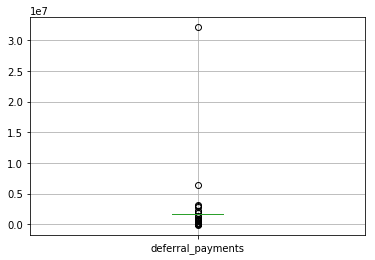

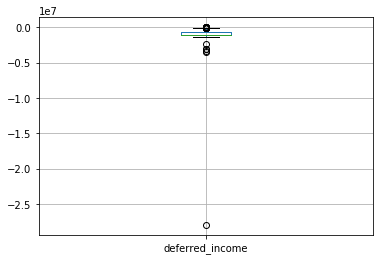

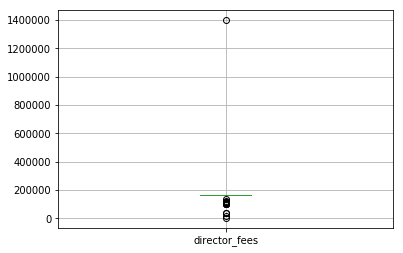

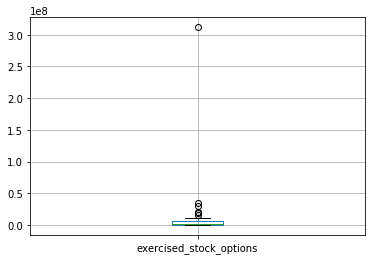

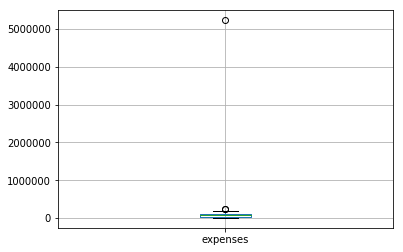

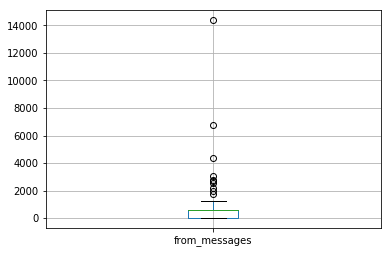

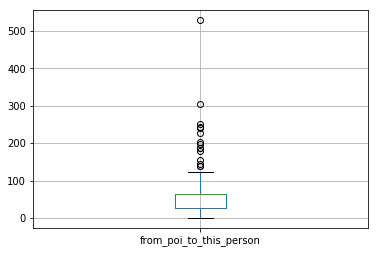

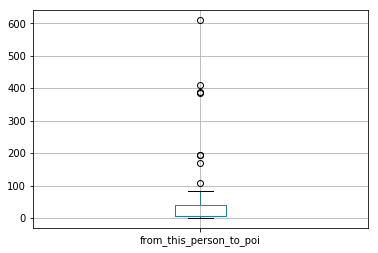

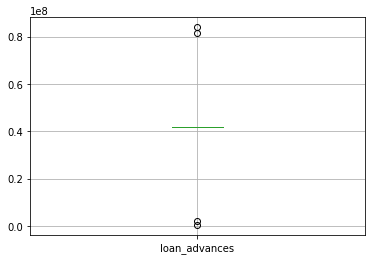

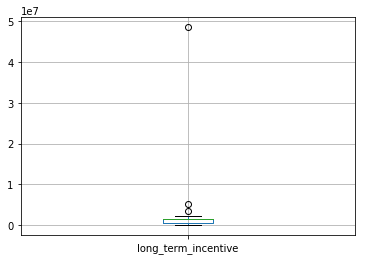

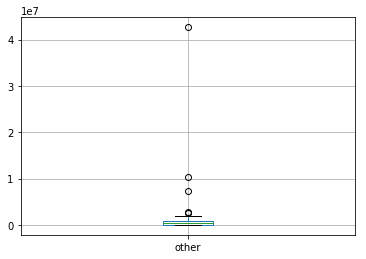

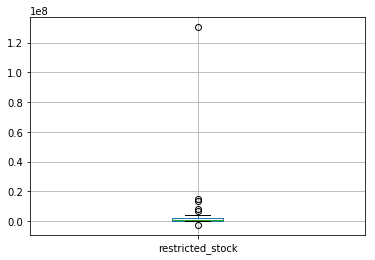

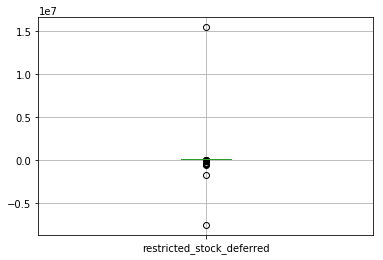

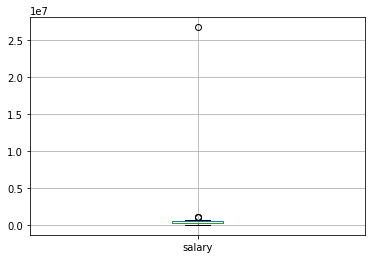

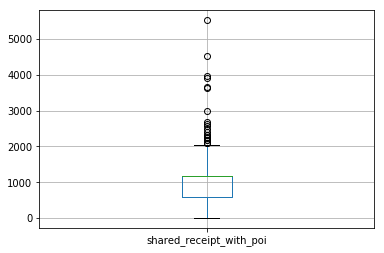

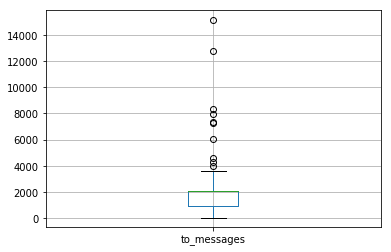

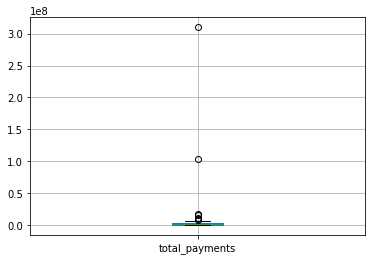

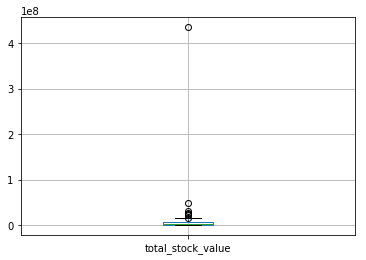

In [8]:
# 檢視這些欄位的數值範圍
for col in numeric_columns:
    df.boxplot(col)    
    plt.show()   

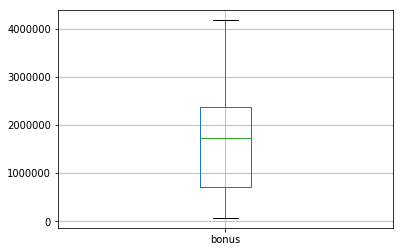

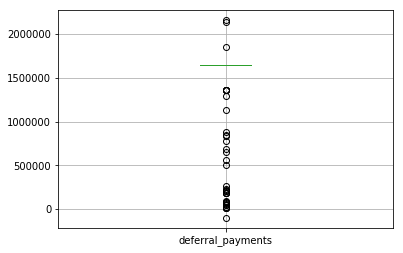

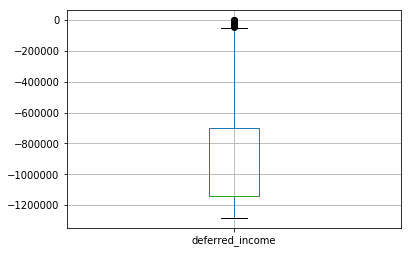

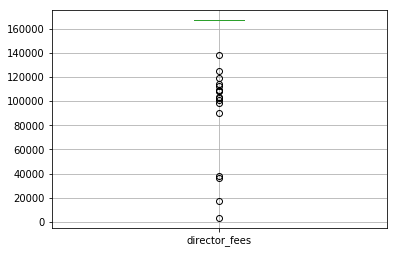

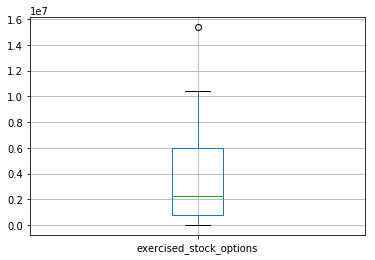

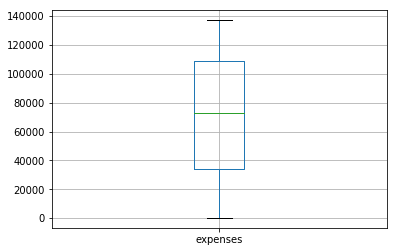

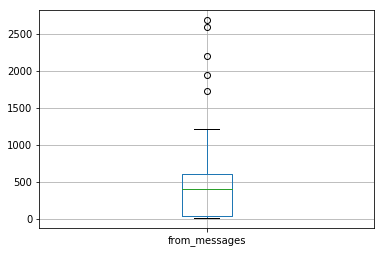

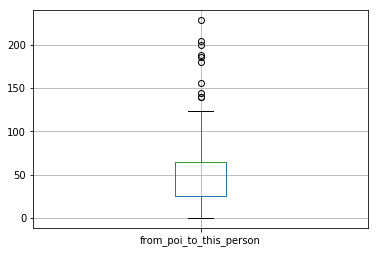

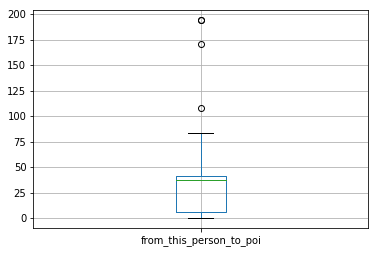

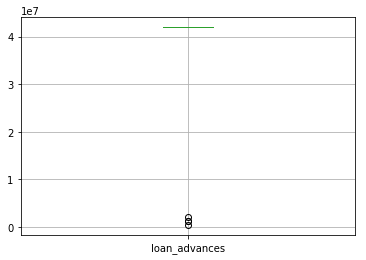

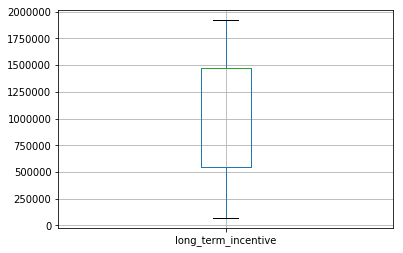

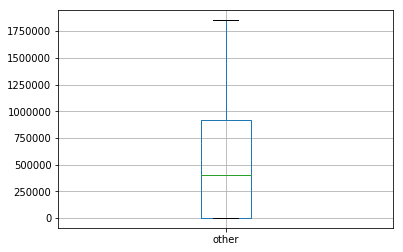

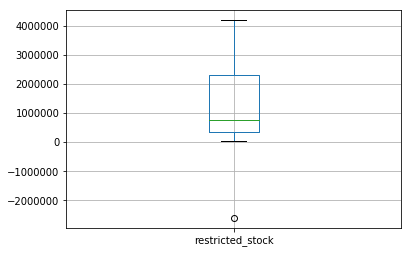

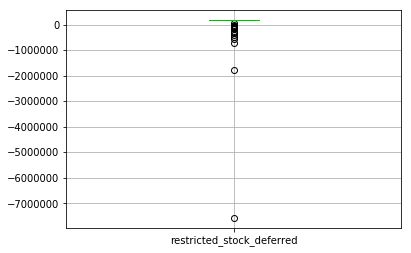

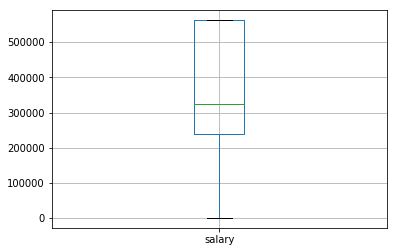

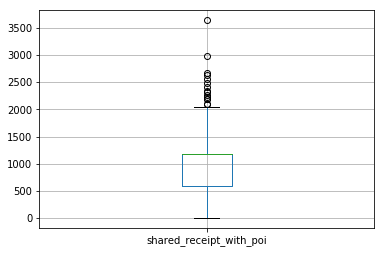

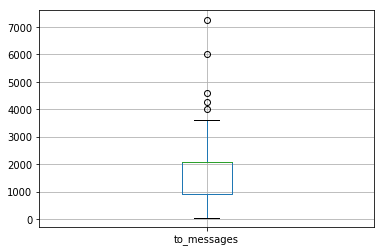

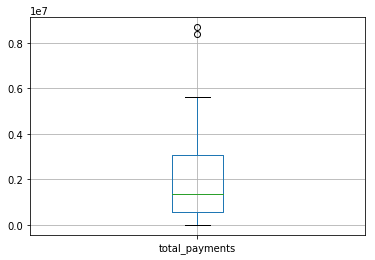

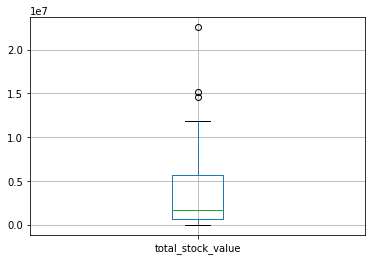

In [10]:
# Replacing outlier values with mean
''' Method 1:
    median = df.loc[df['Age']<75, 'Age'].median()
    df.loc[df.Age > 75, 'Age'] = np.nan
    df.fillna(median,inplace=True) '''
''' Method 2:
    median = df.loc[df['Age']<75, 'Age'].median()
    df["Age"] = np.where(df["Age"] >75, median,df['Age'])'''
''' Method 3:
    median = df.loc[df['Age']<75, 'Age'].median()
    df["Age"] = df["Age"].mask(df["Age"] >75, median)'''

for dtype, col in zip(df[numeric_columns].dtypes, df[numeric_columns].columns):
    if dtype == 'float64':
        if df[col].sum() >= 0:
            mean = df.loc[df[col] < df[col].quantile(0.97), col].mean()
            df[col] = np.where(df[col] > df[col].quantile(0.97), mean, df[col])
            df.boxplot(col)
            plt.show()
        else:
            mean = df.loc[df[col] > df[col].quantile(0.05), col].mean()
            df[col] = np.where(df[col] < df[col].quantile(0.05), mean, df[col])
            df.boxplot(col)
            plt.show()
# df['bonus'] = np.where(df['bonus'] > df['bonus'].quantile(0.95), median, df['bonus'])

In [13]:
fin_features = ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value']
email_features = ['email', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_messages'] 

In [26]:
X = df[:len(df_train)]
y = df_train['poi_code']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

RFC = RandomForestClassifier(n_estimators = 250, min_samples_split = 20, oob_score = True, random_state = 0)
RFC.fit(x_train, y_train)
y_pred = RFC.predict(x_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred):.3f}') # 查看準確率
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred)) # 預測值與實際值的差距，使用 MSE

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

ValueError: setting an array element with a sequence.

### Normalization

== Original data range ==
count    1.460000e+02
mean     1.584714e+06
std      9.021400e+05
min      7.000000e+04
25%      7.125000e+05
50%      1.725000e+06
75%      2.374235e+06
max      4.175000e+06
Name: bonus, dtype: float64


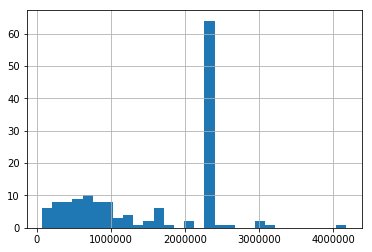


== Normalized data range ==
count    1.460000e+02
mean     1.584714e+06
std      9.021400e+05
min      7.000000e+04
25%      7.125000e+05
50%      1.725000e+06
75%      2.374235e+06
max      4.175000e+06
Name: bonus, dtype: float64


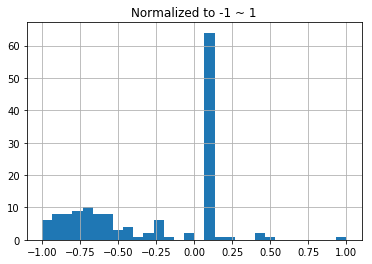

In [17]:
# Normalize values to -1 to 1
def normalize_value(data):
    x_normalized = 2 * ((data - min(data)) / (max(data) - min(data)) - 0.5)
    return x_normalized

In [ ]:
df = df.drop(['poi_code', 'name'] , axis = 1)
train_X = df_train.drop(['poi', 'poi_code', 'name'] , axis = 1)
train_Y = df_train['poi_code']
train_X = df[:len(df_train)]

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(learning_rate = 0.01)
GBC.fit(x_train, y_train)
y_pred = GBC.predict(x_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred):.3f}') # 查看準確率
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred)) # 預測值與實際值的差距，使用 MSE

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

In [ ]:
RFC = RandomForestClassifier()
RFC.fit(x_train, y_train)
y_pred = RFC.predict(x_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred):.3f}') # 查看準確率
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred)) # 預測值與實際值的差距，使用 MSE

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))
